# Working with Pytrees

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb)

*Author: Vladimir Mikulik*

Often, we want to operate on objects that look like dicts of arrays, or lists of lists of dicts, or other nested structures. In JAX, we refer to these as *pytrees*, but you can sometimes see them called *nests*, or just *trees*.

JAX has built-in support for such objects, both in its library functions as well as through the use of functions from [`jax.tree_utils`](https://jax.readthedocs.io/en/latest/jax.tree_util.html) (with the most common ones also available as `jax.tree_*`). This section will explain how to use them, give some useful snippets and point out common gotchas.

## What is a pytree?

As defined in the [JAX pytree docs](https://jax.readthedocs.io/en/latest/pytrees.html):

> a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything thatâ€™s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single â€œleafâ€, i.e. a non-container object, is also considered a pytree.

Some example pytrees:

In [8]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x1276c2ea0>]      has 3 leaves: [1, 'a', <object object at 0x1276c2ea0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


We've also introduced our first `jax.tree_*` function, which allowed us to extract the flattened leaves from the trees.

## Why pytrees?

In machine learning, some places where you commonly find pytrees are:
* Model parameters
* Dataset entries
* RL agent observations

They also often arise naturally when working in bulk with datasets (e.g., lists of lists of dicts).

## Common pytree functions
Perhaps the most commonly used pytree function is `jax.tree_map`. It works analogously to Python's native `map`, but on entire pytrees:

In [9]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

`jax.tree_map` also works with multiple arguments:

In [10]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

When using multiple arguments with `jax.tree_map`, the structure of the inputs must exactly match. That is, lists must have the same number of elements, dicts must have the same keys, etc.

## Example: ML model parameters

A simple example of training an MLP displays some ways in which pytree operations come in useful:

In [11]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

We can use `jax.tree_map` to check that the shapes of our parameters are what we expect:

In [12]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

Now, let's train our MLP:

In [13]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

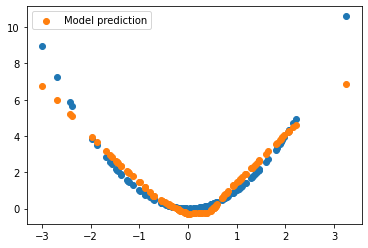

In [14]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

## Custom pytree nodes

So far, we've only been considering pytrees of lists, tuples, and dicts; everything else is considered a leaf. Therefore, if you define your own container class, it will be considered a leaf, even if it has trees inside it:

In [15]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [16]:
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[<__main__.MyContainer at 0x137b1b850>, <__main__.MyContainer at 0x137b1b6a0>]

Accordingly, if we try to use a tree map expecting our leaves to be the elements inside the container, we will get an error:

In [17]:
jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

To solve this, we need to register our container with JAX by telling it how to flatten and unflatten it:

In [ ]:
from typing import Tuple, Iterable

def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

Modern Python comes equipped with helpful tools to make defining containers easier. Some of these will work with JAX out-of-the-box, but others require more care. For instance:

In [ ]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

Notice that the `name` field now appears as a leaf, as all tuple elements are children. That's the price we pay for not having to register the class the hard way.

## Common pytree gotchas and patterns

### Gotchas
#### Mistaking nodes for leaves
A common problem to look out for is accidentally introducing tree nodes instead of leaves:

In [18]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)),
 (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]

What happened is that the `shape` of an array is a tuple, which is a pytree node, with its elements as leaves. Thus, in the map, instead of calling `jnp.ones` on e.g. `(2, 3)`, it's called on `2` and `3`.

The solution will depend on the specifics, but there are two broadly applicable options:
* rewrite the code to avoid the intermediate `tree_map`.
* convert the tuple into an `np.array` or `jnp.array`, which makes the entire
sequence a leaf.

#### Handling of None
`jax.tree_utils` treats `None` as a node without children, not as a leaf:

In [ ]:
jax.tree_util.tree_leaves([None, None, None])

[]

### Patterns
#### Transposing trees

If you would like to transpose a pytree, i.e. turn a list of trees into a tree of lists, you can do so using `jax.tree_map`:

In [ ]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

For more complicated transposes, JAX provides `jax.tree_transpose`, which is more verbose, but allows you specify the structure of the inner and outer Pytree for more flexibility:

In [ ]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}

## More Information

For more information on pytrees in JAX and the operations that are available, see the [Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) section in the JAX documentation.